# Import packages

In [135]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
import os
import glob
import time
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression



from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras.applications.vgg16 as vgg16
from tensorflow.keras.applications.densenet import DenseNet121
import tensorflow.keras.applications.densenet as densenet
from tensorflow.keras.applications.xception import Xception
import tensorflow.keras.applications.xception as xception
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import time

# Load data

In [4]:
# reference: https://www.kaggle.com/gauravrajpal/leukemia-classification-v1-2-xception-66-52

# load training data
train_0_all = glob.glob('cs156 final/training_data/fold_0/all/*.bmp')
train_0_hem = glob.glob('cs156 final/training_data/fold_0/hem/*.bmp')
train_1_all = glob.glob('cs156 final/training_data/fold_1/all/*.bmp')
train_1_hem = glob.glob('cs156 final/training_data/fold_1/hem/*.bmp')
train_2_all = glob.glob('cs156 final/training_data/fold_2/all/*.bmp')
train_2_hem = glob.glob('cs156 final/training_data/fold_2/hem/*.bmp')

In [5]:
# load labels for test data
valid_labels = pd.read_csv('cs156 final/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
valid_labels.head(10)

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1
5,UID_57_8_11_all.bmp,6.bmp,1
6,UID_H49_29_2_hem.bmp,7.bmp,0
7,UID_H30_6_2_hem.bmp,8.bmp,0
8,UID_58_2_1_all.bmp,9.bmp,1
9,UID_54_35_3_all.bmp,10.bmp,1


In [7]:
# stack all training data
train_all = np.hstack((np.array(train_0_all), np.array(train_1_all), np.array(train_2_all)))
train_hem = np.hstack((np.array(train_0_hem), np.array(train_1_hem), np.array(train_2_hem)))

In [8]:
# read and convert images to numpy array for healthy
train_hem_np = []
for i in tqdm(range(len(train_hem))):
    train_hem_np.append(np.array(Image.open(train_hem[i]).resize((100,100))))


100%|██████████| 3389/3389 [00:08<00:00, 419.36it/s]


In [9]:
# read and convert images to numpy array for leukemia
train_all_np = []
for i in tqdm(range(len(train_all))):
    train_all_np.append(np.array(Image.open(train_all[i]).resize((100,100))))

100%|██████████| 7272/7272 [00:18<00:00, 398.90it/s]


In [10]:
# stack healthy and leukemia for training
train_np = np.vstack((np.array(train_all_np), np.array(train_hem_np)))
train_label = np.vstack((np.ones((len(train_all_np),1)), np.zeros((len(train_hem_np),1))))
train_np, train_label = shuffle(train_np, train_label, random_state=123)

In [77]:
# check shape of training set
train_np.shape

(10661, 100, 100, 3)

In [87]:
# proportion of class 1 in training
train_label.sum() / len(train_label)

0.68211237219773

In [152]:
# number of class 1 and class 0 in training
print('leukemia', 10661*0.68211237219773)
print('healthy', 10661 - 10661*0.68211237219773)

leukemia 7272.0
healthy 3389.0


In [78]:
# sample randomly 3000 samples from each class in training to train
ind_bal = shuffle(np.hstack((np.random.choice(np.where(train_label == 1)[0], 3000), np.random.choice(np.where(train_label == 0)[0], 3000))))
X_train = train_np[ind_bal]
y_train = train_label[ind_bal]

100%|██████████| 6/6 [00:00<00:00, 426.85it/s]


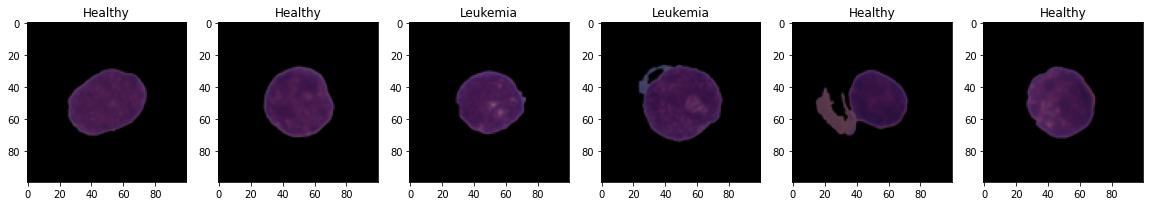

In [98]:
# check out the images for healthy and leukemia
fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (20,20))
for i in tqdm(range(6)):
    ind = np.random.randint(len(X_train))
    ax[i].imshow(X_train[ind])
    if y_train[ind] == 1:
        ax[i].set_title('Leukemia')
    else:
        ax[i].set_title('Healthy')

In [43]:
# load the test set
test_np = []
test_label = []
for i in tqdm(range(valid_labels.shape[0])):
    tail = f'{i+1}.bmp'
    path = 'cs156 final/validation_data/C-NMC_test_prelim_phase_data/' + tail
    test_np.append(np.array(Image.open(path).resize((100,100))))
    test_label.append(valid_labels[valid_labels['new_names'] == tail]['labels'].iloc[0])
test_np = np.array(test_np)
test_label = np.array(test_label).reshape(-1,1)

100%|██████████| 1867/1867 [00:07<00:00, 256.28it/s]


In [79]:
# randomly sample 500 healthy and leukemia samples for test
ind_bal_test = shuffle(np.hstack((np.random.choice(np.where(test_label == 1)[0], 500), np.random.choice(np.where(test_label == 0)[0], 500))))
X_test = test_np[ind_bal_test]
y_test = test_label[ind_bal_test]

# Build the models

## Deep Learning

In [124]:
# reference: https://www.kaggle.com/gauravrajpal/leukemia-classification-v1-2-xception-66-52

# build the deep learning model with transfer learning
def individual_model(app, model_name, path_to_model, X_train, y_train, X_test, y_test, min_delta = 0.00003, k = 0, epochs=20, batch_size=20, threshold=0.5, drop_rate=0.3, class_weight=None):
    # augment the images
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123, test_size=0.2)
    
    datagen  = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=app.preprocess_input)
    datagen.fit(X_train)
    
    # pre-process test data
    X_val = app.preprocess_input(X_val)
    X_test = app.preprocess_input(X_test)
    
    # get the base model
    base_model = model_name(include_top=False, input_shape=(100, 100, 3), weights='imagenet')
    
    # get the output of the base model
    mod = base_model.output
    
    # add new layers on top
    mod = Flatten()(mod)
    mod = Dense(1024, activation='relu')(mod)
    mod = Dropout(drop_rate)(mod)
    mod = Dense(512, activation='relu')(mod)
    mod = Dropout(drop_rate)(mod)
    mod = Dense(256, activation='relu')(mod)
    mod = Dropout(drop_rate)(mod)
    
    # add output layers
    output = Dense(1, activation='sigmoid')(mod)
    
    # start time
    start = time.time()

    # make new model
    model = Model(inputs=base_model.inputs, outputs=output)
    
    # unfreeze k last layers of base model
    for layer in model.layers[:len(base_model.layers)-k]:
        layer.trainable = False
    for layer in model.layers[len(base_model.layers)-k:]:
        layer.trainable = True

    # compile the model
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics = ['accuracy'])

#     model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics = ['accuracy'])
    
    # path to log checkpoints
    filepath = f'./best_weights/{path_to_model}'
    
    # early stopping if no improvement after 10 epochs
    earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                                  mode = 'max' , 
                                  patience = 10,
                                  verbose = 1)
    
    # checkpoint for best performance
    checkpoint = ModelCheckpoint(filepath, 
                                    monitor = 'val_accuracy', 
                                    mode='max', 
                                    save_best_only=True, 
                                    verbose = 1)
    
    # reduce learning rate if no improvement
    learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                      mode = 'max',
                                      patience = 5,
                                      factor = 0.3,
                                      min_delta = min_delta)

    # callbacks
    callbacks = [earlystopping, checkpoint, learning_rate]
    
    # train the model with validation and callbacks
    history = model.fit(datagen.flow(X_train, y_train), epochs=epochs,\
                        validation_data = (X_val, y_val),
                        batch_size = batch_size, class_weight = class_weight, callbacks=callbacks)
    
#     history = model.fit(X_train, y_train, epochs=epochs,\
#                         validation_data = (X_test, y_test),
#                         batch_size = batch_size, class_weight = class_weight, callbacks=callbacks)

    print('training time', time.time() - start)
    
    # test the model
    print('loss and accuracy', model.evaluate(X_test, y_test))

    # get predicted labels based on threshold
    y_pred_prob_train = model.predict(X_train, batch_size=20, verbose=1)
    y_pred_prob = model.predict(X_test, batch_size=20, verbose=1)
    y_pred = [[1] if y_pred_prob[i][0] > threshold else [0] for i in range(len(y_test))]
    
    # detailed report
    print('detailed report')
    print(classification_report(y_test, y_pred))
    print('confusion matrix')
    print(confusion_matrix(y_test, y_pred))
    
    # plot accuracy of train and validation at each epoch
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # return probability for each test sample
    return y_pred_prob_train, y_train, y_pred_prob

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.9696 - accuracy: 0.6492
Epoch 00001: val_accuracy improved from -inf to 0.76833, saving model to ./best_weights/vgg16
INFO:tensorflow:Assets written to: ./best_weights/vgg16/assets
150/150 [==============================] - 31s 206ms/step - loss: 0.9696 - accuracy: 0.6492 - val_loss: 0.4809 - val_accuracy: 0.7683
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6960
Epoch 00002: val_accuracy did not improve from 0.76833
150/150 [==============================] - 27s 182ms/step - loss: 0.6531 - accuracy: 0.6960 - val_loss: 0.4962 - val_accuracy: 0.7550
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.7060
Epoch 00003: val_accuracy improved from 0.76833 to 0.77917, saving model to ./best_weights/vgg16
INFO:tensorflow:Assets written to: ./best_weights/vgg16/assets
150/150 [==============================] - 30s 200ms/step - loss: 0.6094

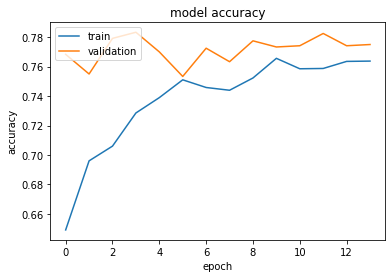

In [140]:
# vgg16, 0 trainable layers in base model
y_pred_prob_train_vgg1, y_train_vgg1, y_pred_prob_vgg1 = individual_model(vgg16, VGG16, 'vgg16', X_train, y_train, X_test, y_test, min_delta = 0.00003, k = 0, epochs=20, batch_size=20, threshold=0.5, drop_rate=0.3, class_weight=None)


Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.6927
Epoch 00001: val_accuracy improved from -inf to 0.75833, saving model to ./best_weights/vgg16_2
INFO:tensorflow:Assets written to: ./best_weights/vgg16_2/assets
150/150 [==============================] - 76s 506ms/step - loss: 0.6288 - accuracy: 0.6927 - val_loss: 0.4849 - val_accuracy: 0.7583
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.7544
Epoch 00002: val_accuracy improved from 0.75833 to 0.77833, saving model to ./best_weights/vgg16_2
INFO:tensorflow:Assets written to: ./best_weights/vgg16_2/assets
150/150 [==============================] - 73s 488ms/step - loss: 0.5093 - accuracy: 0.7544 - val_loss: 0.4780 - val_accuracy: 0.7783
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7671
Epoch 00003: val_accuracy did not improve from 0.77833
150/150 [==============================] - 70s 466ms/step - loss

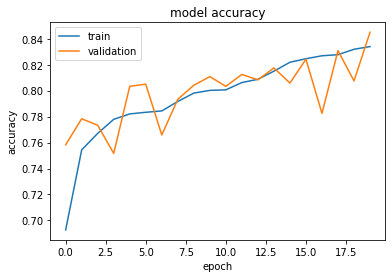

In [141]:
# vgg16, 7 trainable layers in base model
y_pred_prob_train_vgg2, y_train_vgg2, y_pred_prob_vgg2 = individual_model(vgg16, VGG16, 'vgg16_2', X_train, y_train, X_test, y_test, min_delta = 0.00003, k = 7, epochs=20, batch_size=20, threshold=0.5, drop_rate=0.3, class_weight=None)


Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.6098
Epoch 00001: val_accuracy improved from -inf to 0.72417, saving model to ./best_weights/xception
INFO:tensorflow:Assets written to: ./best_weights/xception/assets
150/150 [==============================] - 43s 286ms/step - loss: 0.6578 - accuracy: 0.6098 - val_loss: 0.5801 - val_accuracy: 0.7242
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.6992
Epoch 00002: val_accuracy improved from 0.72417 to 0.73417, saving model to ./best_weights/xception
INFO:tensorflow:Assets written to: ./best_weights/xception/assets
150/150 [==============================] - 40s 264ms/step - loss: 0.5830 - accuracy: 0.6992 - val_loss: 0.5387 - val_accuracy: 0.7342
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7254
Epoch 00003: val_accuracy improved from 0.73417 to 0.74333, saving model to ./best_weights/xception
INFO:tensorflow

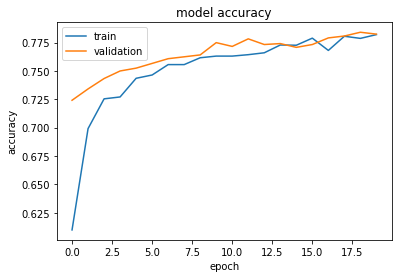

In [142]:
# xception, 0 trainable layers in base model
y_pred_prob_train_xception1, y_train_xception1, y_pred_prob_xception1 = individual_model(xception, Xception, 'xception', X_train, y_train, X_test, y_test, min_delta = 0.00003, k = 0, epochs=20, batch_size=20, threshold=0.5, drop_rate=0.3, class_weight=None)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5610
Epoch 00001: val_accuracy improved from -inf to 0.58833, saving model to ./best_weights/xception_2
INFO:tensorflow:Assets written to: ./best_weights/xception_2/assets
150/150 [==============================] - 45s 301ms/step - loss: 0.6861 - accuracy: 0.5610 - val_loss: 0.6622 - val_accuracy: 0.5883
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6540
Epoch 00002: val_accuracy improved from 0.58833 to 0.73500, saving model to ./best_weights/xception_2
INFO:tensorflow:Assets written to: ./best_weights/xception_2/assets
150/150 [==============================] - 43s 287ms/step - loss: 0.6517 - accuracy: 0.6540 - val_loss: 0.6008 - val_accuracy: 0.7350
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7008
Epoch 00003: val_accuracy improved from 0.73500 to 0.74500, saving model to ./best_weights/xception_2
INFO:

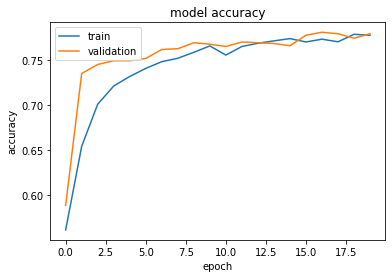

In [143]:
# xception, 7 trainable layers in base model
y_pred_prob_train_xception2, y_train_xception2, y_pred_prob_xception2 = individual_model(xception, Xception, 'xception_2', X_train, y_train, X_test, y_test, min_delta = 0.00003, k = 7, epochs=20, batch_size=20, threshold=0.5, drop_rate=0.3, class_weight=None)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.6317
Epoch 00001: val_accuracy improved from -inf to 0.72833, saving model to ./best_weights/densenet
INFO:tensorflow:Assets written to: ./best_weights/densenet/assets
150/150 [==============================] - 69s 460ms/step - loss: 0.6944 - accuracy: 0.6317 - val_loss: 0.5319 - val_accuracy: 0.7283
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.6994
Epoch 00002: val_accuracy improved from 0.72833 to 0.73833, saving model to ./best_weights/densenet
INFO:tensorflow:Assets written to: ./best_weights/densenet/assets
150/150 [==============================] - 67s 446ms/step - loss: 0.5845 - accuracy: 0.6994 - val_loss: 0.5151 - val_accuracy: 0.7383
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7217
Epoch 00003: val_accuracy improved from 0.73833 to 0.74083, saving model to ./best_weights/densenet
INFO:tensorflow

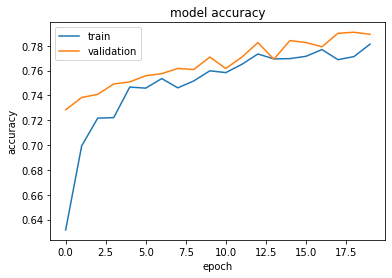

In [144]:
# densenet, 0 trainable layers in base model
y_pred_prob_train_densenet1, y_train_densenet1, y_pred_prob_densenet1 = individual_model(densenet, DenseNet121, 'densenet', X_train, y_train, X_test, y_test, min_delta = 0.00003, k = 0, epochs=20, batch_size=20, threshold=0.5, drop_rate=0.3, class_weight=None)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.6521
Epoch 00001: val_accuracy improved from -inf to 0.73917, saving model to ./best_weights/densenet_2
INFO:tensorflow:Assets written to: ./best_weights/densenet_2/assets
150/150 [==============================] - 74s 492ms/step - loss: 0.6708 - accuracy: 0.6521 - val_loss: 0.5260 - val_accuracy: 0.7392
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.7067
Epoch 00002: val_accuracy improved from 0.73917 to 0.75167, saving model to ./best_weights/densenet_2
INFO:tensorflow:Assets written to: ./best_weights/densenet_2/assets
150/150 [==============================] - 70s 464ms/step - loss: 0.5965 - accuracy: 0.7067 - val_loss: 0.4930 - val_accuracy: 0.7517
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.5604 - accuracy: 0.7231
Epoch 00003: val_accuracy improved from 0.75167 to 0.76500, saving model to ./best_weights/densenet_2
INFO:

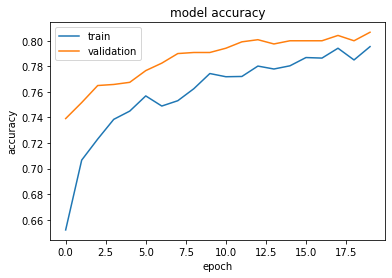

In [145]:
# densenet, 7 trainable layers in base model
y_pred_prob_train_densenet2, y_train_densenet2, y_pred_prob_densenet2 = individual_model(densenet, DenseNet121, 'densenet_2', X_train, y_train, X_test, y_test, min_delta = 0.00003, k = 7, epochs=20, batch_size=20, threshold=0.5, drop_rate=0.3, class_weight=None)

## Traditional ML

In [170]:
# reference: https://colab.research.google.com/drive/1OPKdqvyUyFQ9gCOto2dGqc5z9AdtoVIN

# transform the data with pca
def pca(X_train, X_test, n):
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

# transform the data with lda
def lda(X_train, X_test, y_train):
    lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.5)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    return X_train_lda, X_test_lda

# logistic regression
def logistic_regression(X_train, X_test, y_train, y_test, threshold=0.5):
    start = time.time()
    # build the model
    lr = LogisticRegressionCV(solver='liblinear')
    # fit the model
    lr.fit(X_train, y_train)
    print('running time: ', time.time()-start)
    # predict with train and test data
    y_train_pred = lr.predict(X_train)
    y_test_pred = np.where(lr.predict_proba(X_test)[:,1] > threshold, 1, 0)
    # print the results
    print('accuracy for train: ', accuracy_score(y_train, y_train_pred))
    print('accuracy for test: ', accuracy_score(y_test, y_test_pred))
    print('confusion matrix: ', confusion_matrix(y_test, y_test_pred))
    return lr.predict_proba(X_train), lr.predict_proba(X_test)

def rfc(X_train, X_test, y_train, y_test):
    # cross validation for random forest classifier
    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }

    rfc_ = RandomForestClassifier(random_state=123)
    grc = GridSearchCV(rfc_, param_grid=param_grid, cv=7)
    grc.fit(X_train_lda, y_train)
    params = grc.best_params_

    # build random forest classifier
    rfc = RandomForestClassifier(random_state=123, max_features=params['max_features'],\
                                 n_estimators= params['n_estimators'], max_depth=params['max_depth'], criterion=params['criterion'])
    # fit the model
    rfc.fit(X_train, y_train)
    # predict on train and test
    y_train_pred = rfc.predict(X_train)
    y_test_pred = rfc.predict(X_test)
    
    print('accuracy for train: ', accuracy_score(y_train, y_train_pred))
    print('accuracy for test: ', accuracy_score(y_test, y_test_pred))
    return rfc.predict_proba(X_train), rfc.predict_proba(X_test)

In [110]:
# flatten data
X_train_flatten = np.array([X_train[i].flatten() for i in range(len(X_train))])
X_test_flatten = np.array([X_test[i].flatten() for i in range(len(X_test))])

In [112]:
# transform data with pca and lda
X_train_pca, X_test_pca = pca(X_train_flatten, X_test_flatten, 50)
X_train_lda, X_test_lda = lda(X_train_flatten, X_test_flatten, y_train.ravel())

In [172]:
# linear regression on pca-transformed data
y_pred_prob_pca_lr_train,  y_pred_prob_pca_lr_test = logistic_regression(X_train_pca, X_test_pca, y_train.ravel(), y_test.ravel(), threshold = 0.5)

running time:  10.490171194076538
accuracy for train:  0.7741666666666667
accuracy for test:  0.598
confusion matrix:  [[198 302]
 [100 400]]


In [151]:
# linear regression on lda-transformed data
y_pred_prob_lda_lr_train,  y_pred_prob_lda_lr_test = logistic_regression(X_train_lda, X_test_lda, y_train.ravel(), y_test.ravel(), , threshold = 0.5)

running time:  0.20975112915039062
accuracy for train:  0.897
accuracy for test:  0.59
confusion matrix:  [[237 263]
 [147 353]]


In [138]:
# random forest classifier on pca-transformed data
y_pred_prob_pca_rfc_train,  y_pred_prob_pca_rfc_test = rfc(X_train_pca, X_test_pca, y_train.ravel(), y_test.ravel())

accuracy for train:  0.8736666666666667
accuracy for test:  0.588


## Combined outputs

In [159]:
# combine the training predicted probabilities of logistic regression and random forest classifier
train_probs = np.hstack((y_pred_prob_pca_lr_train[:, 1].reshape(-1,1), y_pred_prob_lda_lr_train[:, 1].reshape(-1,1), y_pred_prob_pca_rfc_train[:, 1].reshape(-1,1)))
train_probs

array([[0.01843482, 0.00233519, 0.05363039],
       [0.04834813, 0.01931042, 0.07878626],
       [0.76216741, 0.99451645, 0.61355708],
       ...,
       [0.80390993, 0.88128137, 0.77041916],
       [0.71174946, 0.76396806, 0.84654317],
       [0.83952279, 0.25583959, 0.67885789]])

In [160]:
# combine the test predicted probabilities of logistic regression and random forest classifier
test_probs = np.hstack((y_pred_prob_pca_lr_test[:, 1].reshape(-1,1), y_pred_prob_lda_lr_test[:, 1].reshape(-1,1), y_pred_prob_pca_rfc_test[:, 1].reshape(-1,1)))
test_probs

array([[0.45777932, 0.08109445, 0.69083502],
       [0.81604671, 0.6485476 , 0.76819172],
       [0.87916245, 0.97777132, 0.73426752],
       ...,
       [0.49003854, 0.9545559 , 0.57672728],
       [0.57983259, 0.03566045, 0.70365834],
       [0.75967672, 0.90817719, 0.73855011]])

In [188]:
# test the combined model with different classification thresholds
for j in np.linspace(0.5, 0.9, 10):
    print('threshold: ', j)
    logistic_regression(train_probs, test_probs, y_train.ravel(), y_test.ravel(), threshold = j)
    print('----------------------------')

threshold:  0.5
running time:  0.293597936630249
accuracy for train:  0.9568333333333333
accuracy for test:  0.566
confusion matrix:  [[175 325]
 [109 391]]
----------------------------
threshold:  0.5444444444444444
running time:  0.3421592712402344
accuracy for train:  0.9568333333333333
accuracy for test:  0.566
confusion matrix:  [[184 316]
 [118 382]]
----------------------------
threshold:  0.5888888888888889
running time:  0.3535337448120117
accuracy for train:  0.9568333333333333
accuracy for test:  0.564
confusion matrix:  [[191 309]
 [127 373]]
----------------------------
threshold:  0.6333333333333333
running time:  0.3530902862548828
accuracy for train:  0.9568333333333333
accuracy for test:  0.572
confusion matrix:  [[211 289]
 [139 361]]
----------------------------
threshold:  0.6777777777777778
running time:  0.352189302444458
accuracy for train:  0.9568333333333333
accuracy for test:  0.573
confusion matrix:  [[217 283]
 [144 356]]
----------------------------
thresho

In [168]:
# combine the training predicted probabilities of 3 Deep Learning models 
train_probs_2 = np.hstack((y_pred_prob_train_vgg2, y_pred_prob_train_xception2, y_pred_prob_train_densenet2))
# combine the training predicted probabilities of 3 Deep Learning models
test_probs_2 = np.hstack((y_pred_prob_vgg2, y_pred_prob_xception2, y_pred_prob_densenet2))

In [189]:
# test the combined model with different classification thresholds
for j in np.linspace(0.5, 0.9, 10):
    print('threshold: ', j)
    logistic_regression(train_probs_2, test_probs_2, y_train_densenet2.ravel(), y_test.ravel(), threshold = j)
    print('----------------------------')

threshold:  0.5
running time:  0.21611738204956055
accuracy for train:  0.7970833333333334
accuracy for test:  0.662
confusion matrix:  [[249 251]
 [ 87 413]]
----------------------------
threshold:  0.5444444444444444
running time:  0.27676916122436523
accuracy for train:  0.7970833333333334
accuracy for test:  0.677
confusion matrix:  [[269 231]
 [ 92 408]]
----------------------------
threshold:  0.5888888888888889
running time:  0.2768261432647705
accuracy for train:  0.7970833333333334
accuracy for test:  0.69
confusion matrix:  [[286 214]
 [ 96 404]]
----------------------------
threshold:  0.6333333333333333
running time:  0.2769310474395752
accuracy for train:  0.7970833333333334
accuracy for test:  0.695
confusion matrix:  [[299 201]
 [104 396]]
----------------------------
threshold:  0.6777777777777778
running time:  0.27771425247192383
accuracy for train:  0.7970833333333334
accuracy for test:  0.704
confusion matrix:  [[321 179]
 [117 383]]
----------------------------
thr